# Approximating Likelihood Ratios with Calibrated Discriminative Classifiers: Signal Strength in Mixture Models

In this notebook, techniques described in the paper [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](https://arxiv.org/abs/1506.02169) (in particular section 3.4) are adapted to signal strength fits in models with multiple background components. Toy data is generated with `make_classification` for that purpose.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

The central piece of this example can not be found in this notebook, but gets imported from [geeksw](https://github.com/guitargeek/geeksw/):

In [22]:
from geeksw.stats.likelihood import PairwiseLikelihoodRatioModel, minimize_likelihood

## Sample Generation

How many components will our toy model have? The first component will be defined as the signal component. The weights for the true mixture also have to be defined. The  weights should be of length `n_classes - 1`, as the weight of the last component is inferred automatically from the normalization.

In [3]:
n_classes = 2
weights = [0.05]
n_events = 500000

Define the random statue for toy model and samle splitting:

In [4]:
random_state = 79

Generate events from toy model:

In [5]:
X, y = make_classification(n_samples=n_events,
                           n_features=20,
                           n_informative=5,
                           random_state=random_state,
                           n_classes=n_classes,
                           weights=weights)

I split the generated events in 3 parts:
1. __training__: will be used to train the classifiers for distinguishing one component from another
1. __calibration__: the likelihood ratios are calibrated by running the classifiers on this sample and histogramming of the predictions
1. __testing__: about 80 % of the generated events will be in this subsample. It is used to validate the calibration by repeadetly drawing random subsamples of __testing__ that are of the same size as the sample used for __calibration__, veryfinig the calibration is consitent on a statistical basis


In [6]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.9, random_state=random_state)
X_calib, X_test, y_calib, y_test = train_test_split(X_, y_, test_size=0.9, random_state=random_state+99)

In [7]:
print("n_test: {0}".format(len(X_train)))
print("n_calib: {0}".format(len(X_calib)))
print("n_test: {0}".format(len(X_test)))

n_test: 50000
n_calib: 45000
n_test: 405000


## Training the Classifiers and Make Pairwise Predictions

Let's train `(n**2 - n)/2` [xgboost](https://xgboost.readthedocs.io/en/latest/) classifiers for pairwise classification of the components. The number $n$ stands here for the number of components.

I use `binary:logitraw` to obtain the classifier score before the logistic transformtion as my model predictions. The logistic transformation is not necessary, as we will recalibrate the output anyway, and the score before the transformation behaves more Gaussian-like which is better for the later treatment.

In [8]:
params = dict(objective="binary:logitraw")
num_round = 100

In [9]:
models = [[None] * n_classes for i in range(n_classes)]
for i in range(n_classes):
    for j in range(n_classes):
        if i <= j:
            continue
        print(f"Training model {i} vs {j}...")
        m = np.logical_or(y_train == i, y_train == j)
        dtrain = xgb.DMatrix(X_train[m], label=np.array(y_train[m] == i, dtype=np.int))
        models[i][j] = xgb.train(params, dtrain, num_round)
        models[j][i] = models[i][j]

Training model 1 vs 0...


Now, let's run the models on all our samples:

In [10]:
preds_train = np.zeros((len(y_train), n_classes, n_classes))
preds_calib = np.zeros((len(y_calib), n_classes, n_classes))
preds_test = np.zeros((len(y_test), n_classes, n_classes))

In [11]:
dtrain = xgb.DMatrix(X_train)
dcalib = xgb.DMatrix(X_calib)
dtest = xgb.DMatrix(X_test)

In [12]:
for i in range(n_classes):
    for j in range(n_classes):
        if i == j:
            continue
        preds_train[:,i,j] = models[i][j].predict(dtrain)
        preds_calib[:,i,j] = models[i][j].predict(dcalib)
        preds_test[:,i,j] = models[i][j].predict(dtest)

        if i < j:
            preds_train[:,i,j] = -preds_train[:,i,j]
            preds_calib[:,i,j] = -preds_calib[:,i,j]
            preds_test[:,i,j] = -preds_test[:,i,j]

For every event, the predictions will be a symmetric square matrix of size `n_classes`, where the element `[i,j]` corresponds to the score of the event being in component `i` versus component `j`. The diagonal is zero, as we can't separate a component from itself. Here, as an example the scores for the first event in the testing sample:

In [13]:
preds_test[0]

array([[ 0.        , -6.07071686],
       [ 6.07071686,  0.        ]])

As we anticipate, predictions from the _0 vs 1_ model are highest for the component 0, lowest for the component 1 and somewhere in between for the other components (if any).

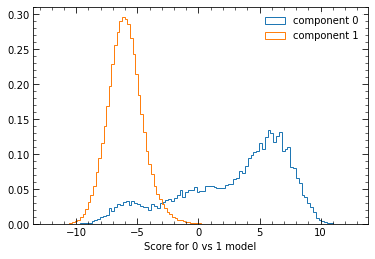

In [14]:
for i in range(n_classes):
    plt.hist(preds_test[:,0,1][y_test == i], bins=100, histtype="step", density=True, label="component "+str(i))
plt.xlabel("Score for 0 vs 1 model")
plt.legend()
plt.show()

## Precomputing the Likelihood Ratios

For the likelihood-free inference, in the case where our model parameter is only a factor in the weight of the signal component (also called the signal strength $\mu$), we need to compute the likelihood ratios that a given event is in one component versus another, so we can ultimately apply formula 3.5 from [the paper](https://arxiv.org/pdf/1506.02169.pdf).

If not for overtraining effects, one could simply use the classification scores after logistic transformation. In reality, we need to recalibrate. This can be done for example with kernel density estimates, histogram based methods or isotonic regression (as the substitute for the likelihood ratio increases monotonically).

I choose histogramming for the recalibration, as it seems to me this is most promising to also incorporate systematic uncertainties later. A natural next step would be for example to include the uncertainty due to limited statistics in the calibration sample, which could be accounted for with Poission errors in the number of entries.

### Finding the Binning of the Histograms

The usual question for histogram-based methods is the realization of the binning. The number of bins for each pairwise likelihood ratio is a free parameter of my approach. With the number of bins given, the location of their edges will be found by throwing decision trees at the scores. The dicision boundaries of these simple trees will then be used as the bin edges.

### The `PairwiseLikelihoodRatioModel` Class

This class is used for the transformation from the matrix with binary scores to likelihood ratios based on the histogram-based approach described above. It's `fit()` function takes the binary scores and true component indices for the calibration sample and fills the histograms. The `predict()` function takes just the binary score matrix, looks up the correcponding likelihood ratios in the histograms and returns them.

In [15]:
likelihood_model = PairwiseLikelihoodRatioModel(n_bins=40).train(preds_calib, y_calib)

/home/jonas/.local/lib/python3.7/site-packages/geeksw/stats/likelihood.py:71: RuntimeWarning: divide by zero encountered in true_divide
  self._r_hist[i][j] = hist_j / hist_i
/home/jonas/.local/lib/python3.7/site-packages/geeksw/stats/likelihood.py:80: RuntimeWarning: divide by zero encountered in true_divide
  self._r_hist[j][i] = (hist_i / hist_j)[::-1]


### Evaluating the Likelihood Ratio for a Given Signal Strength

### Calibration Sample

Ok, let us start with the classic likelihood scan over the signal strength $\mu$.

For this, we will use the last method of the `PairwiseLikelihoodRatioModel` class, which is called `make_likelihood_function()`. You have to pass it a binary scores matrix and it will return a function. This function is the actual likelihood function for the observed scores, and you only need to pass it the signal strength $\mu$ to evaluatue it.

We will do the likelihood scan for the calibration sample, so we can cross-check if the calibration was performed correctly. If everything went well, the minimum should be exactly at 1.0.

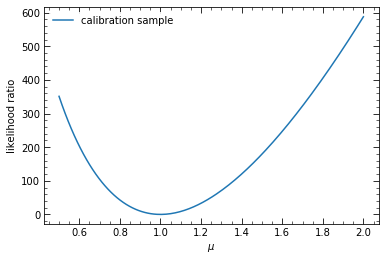

best mu: 1.0000004009516328


In [19]:
mus = np.linspace(0.5, 1/0.5, 200)
res = np.zeros_like(mus)

func = likelihood_model.make_likelihood_function(preds_calib)
for k, m in enumerate(mus):
    res[k] = func(m)
plt.plot(mus, res, label="calibration sample")
plt.ylabel("likelihood ratio")
plt.xlabel(r"$\mu$")
plt.legend()
plt.show()

print("best mu: " + str(minimize_likelihood(func)[0]))

If the minimum is not be at one, this can mean one of two things:
1. The classifiers were not fitting the likelihood ratios well
2. You did not choose enough bins for the decision trees in the likelihood model, therefore underfitting the likelihood ratio and introducing a bias

### Testing Sample

Finally, we will apply the model to some unseen testing samples. To generate these testing samples, we first draw a random number $n_i$ from a Poisson distribution with $\lambda$ = `len(X_calib)` and then take $n_i$ random events out of the testing sample.

For each drawn sample, we compute the signal strength and uncertainty by minimizing the log-likelihood.

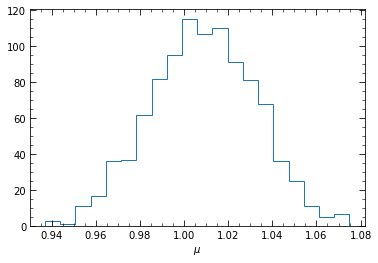

fraction in confidence interval: 62.40 %
mean of pull distribution: 0.3537
std of pull distribution: 1.0067


In [23]:
n_samples = 1000

fitted_mu = np.zeros(n_samples)
fitted_mu_err = np.zeros(n_samples)
is_in_confidence_interval = np.zeros(n_samples, dtype=np.bool)

for l in range(n_samples):

    n_tot = np.random.poisson(lam=len(y_calib), size=1)[0]

    selection_test = np.random.choice(np.arange(len(preds_test)), size=n_tot)

    func = likelihood_model.make_likelihood_function(preds_test[selection_test])
    
    best_mu, interval = minimize_likelihood(func)

    fitted_mu[l] = best_mu
    is_in_confidence_interval[l] = interval[1] > 1. and interval[0] < 1.
    fitted_mu_err[l] = np.max(np.abs(interval - best_mu))

plt.hist(fitted_mu, bins=20, histtype="step")
plt.xlabel(r"$\mu$")
plt.show()
    
frac_in_cf = np.sum(is_in_confidence_interval)/len(is_in_confidence_interval)
print("fraction in confidence interval: {0:.2f} %".format(frac_in_cf * 100))
pulls = (fitted_mu - 1) / fitted_mu_err
print("mean of pull distribution: {0:.4f}".format(np.mean(pulls)))
print("std of pull distribution: {0:.4f}".format(np.std(pulls)))

If the behaviour of our likelihood substitute is correct, about 69 % of the experiments should have covered the true value with their confidence interval. The mean of the pull distribution should be zero and it's standard deviation one.

A bias in the pull distribution or other inconsistencies could either stem from the same issues which caused the best fit in the cross-check with the calibration sample to not be 1, or, in case the cross-check was successful, indicate an over-fitting of the calibration, i.e. too many bins in the histograms.